### url for challenge : https://www.hackerearth.com/challenges/competitive/garden-nerd-data-science-competition/

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# !unzip gdrive/My\ Drive/HE_Challenge_data

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


## Data Pipeline

In [0]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [4]:
train.tail(3)

,image_id,category
18537,18537,78
18538,18538,74
18539,18539,29


In [5]:
test.head(3)

,image_id,category
0,18540,NaN
1,18541,NaN
2,18542,NaN


In [6]:
sample.head(3)

,image_id,category
0,18540,0
1,18541,0
2,18542,0


In [0]:
train = train.values

In [0]:
folders, num_samples = np.unique(train[:, 1], return_counts=True)

In [0]:
for folder in folders:
  p = os.path.join('data/train', str(folder))
  if not os.path.isdir(p):
    os.mkdir(p)

In [0]:
# make subdirectory of each class
for i in range(train.shape[0]):
  dest = os.path.join('data/train/', str(train[i][1]))
  src = os.path.join('data/train', str(train[i][0]) + '.jpg')
  shutil.move(src, dest)
  

#### validation - training split

In [0]:
SPLIT = 0.95 # 95% for training 5% for validation  

In [0]:
# create the validation directory
if not os.path.isdir('data/val'):
  os.mkdir('data/val')

In [0]:
# creating subdirectories (of each category) in validation directory
for folder in folders:
  p = os.path.join('data/val', str(folder))
  if not os.path.isdir(p):
    os.mkdir(p)

In [0]:
# move the 5% data from training directory to validation directory

for f in folders:
  path = 'data/train/'+str(f)
  imgs = os.listdir(path)
  split_size = int(SPLIT*len(imgs))
  file_to_move = imgs[split_size:]
  
  for img_f in file_to_move:
    src = os.path.join(path, img_f)
    dest = os.path.join('data/val/'+str(f), img_f)
    shutil.move(src, dest)


In [0]:
# print('training data')
# for f in folders:
#   path = 'data/train/'+str(f)
#   print(str(f) + " " + str(len(os.listdir(path))))

# print('validation data')
# for f in folders:
#   path = 'data/val/'+str(f)
#   print(str(f) + " " + str(len(os.listdir(path))))

#### Data Augmentation


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.4,
    zoom_range = 0.3,
    horizontal_flip = True
)
val_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
)


In [51]:
train_gen = train_img_gen.flow_from_directory(
    'data/train',
    batch_size = 32,
    

)
val_gen = val_img_gen.flow_from_directory(
    'data/val/',
)

Found 17562 images belonging to 102 classes.
Found 978 images belonging to 102 classes.


In [27]:
for (x, y) in train_gen:
  print(x.shape, y.shape)
  break

(256, 256, 256, 3) (256, 102)


### Claasifier Model - EfficientNet

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

##### Callback  and Checkpoints

In [0]:
from tensorboardcolab import *
from keras.callbacks import Callback, TensorBoard, EarlyStopping

In [30]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://ee953183.ngrok.io


In [0]:
# os.mkdir('logs')

In [0]:
tb = TensorBoard('./logs')
es = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=5)

#### Model Architecture

In [0]:
from keras_efficientnets import EfficientNetB0

In [35]:
model = EfficientNetB0((256, 256, 3), classes=102, include_top=False, weights='imagenet')

16719872/16717576 [==============================] - 2s 0us/step


In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 128, 128, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 128, 128, 32) 128         conv2d_219[0][0]                 
__________________________________________________________________________________________________
swish_164 (Swish)               (None, 128, 128, 32) 0           batch_normalization_164[0][0]    
__________________________________________________________________________________________________
depthwise_

In [0]:
### adding output layer for flower classification
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256, activation='relu')(av1)
d1 = Dropout(0.25)(fc1)

fc2 = Dense(102, activation='softmax')(d1)

In [0]:
model = Model(model.input, outputs  = fc2)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 128, 128, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 128, 128, 32) 128         conv2d_219[0][0]                 
__________________________________________________________________________________________________
swish_164 (Swish)               (None, 128, 128, 32) 0           batch_normalization_164[0][0]    
__________________________________________________________________________________________________
depthwise_

#### compilation and training

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
hist = model.fit_generator(train_gen, steps_per_epoch=17562//32, validation_data=val_gen, validation_steps=978//32, epochs=20, callbacks=[TensorBoardColabCallback(tbc), tb, es])

Epoch 1/20
548/548 [==============================] - 525s 959ms/step - loss: 0.9053 - acc: 0.7773 - val_loss: 0.4231 - val_acc: 0.8917
Epoch 2/20
548/548 [==============================] - 494s 901ms/step - loss: 0.2743 - acc: 0.9222 - val_loss: 0.2595 - val_acc: 0.9239
Epoch 3/20
548/548 [==============================] - 497s 906ms/step - loss: 0.2209 - acc: 0.9380 - val_loss: 0.2129 - val_acc: 0.9429
Epoch 4/20
548/548 [==============================] - 497s 908ms/step - loss: 0.1827 - acc: 0.9466 - val_loss: 0.2624 - val_acc: 0.9302
Epoch 5/20
548/548 [==============================] - 498s 910ms/step - loss: 0.1495 - acc: 0.9569 - val_loss: 0.2238 - val_acc: 0.9345
Epoch 6/20
548/548 [==============================] - 503s 918ms/step - loss: 0.1342 - acc: 0.9613 - val_loss: 0.3231 - val_acc: 0.9281


In [0]:
def plot_loss_accuracy():
  # plot loss
  print("training_loss =", hist.history['loss'][-1],  "   val_loss =", hist.history['val_loss'][-1])
  print("training_acc =", hist.history['acc'][-1]*100, "   val_acc =", hist.history['val_acc'][-1]*100)
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='training_loss')

  # plot accuracy
  plt.plot(hist.history['val_acc'], label='val_acc')
  plt.plot(hist.history['acc'], label='training_acc')
  plt.legend()
  plt.show()


training_loss = 0.13418478632990763    val_loss = 0.32313381647395784
training_acc = 96.13234455219623    val_acc = 92.81183927306161


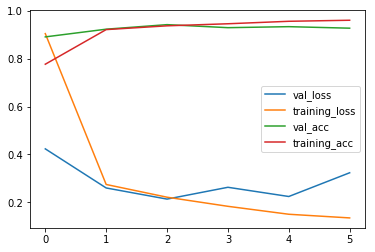

In [54]:
plot_loss_accuracy()

### Predictions

In [0]:
if not os.path.isdir('data/test/test_data'):
  os.mkdir('data/test/test_data')

In [0]:
# make subdirectory of each class
for each in os.listdir('data/test/'):
  dest = 'data/test/test_data'
  src = os.path.join('data/test', each)
  shutil.move(src, dest)

In [67]:
os.listdir('data/test/test_data')

['20520.jpg',
 '18962.jpg',
 '20347.jpg',
 '18817.jpg',
 '20228.jpg',
 '18964.jpg',
 '19959.jpg',
 '19870.jpg',
 '19834.jpg',
 '19634.jpg',
 '18868.jpg',
 '19738.jpg',
 '19908.jpg',
 '18595.jpg',
 '19402.jpg',
 '19359.jpg',
 '20321.jpg',
 '20007.jpg',
 '18951.jpg',
 '20524.jpg',
 '19946.jpg',
 '18790.jpg',
 '18904.jpg',
 '19305.jpg',
 '19881.jpg',
 '19178.jpg',
 '19652.jpg',
 '18653.jpg',
 '20202.jpg',
 '18791.jpg',
 '19370.jpg',
 '18660.jpg',
 '19401.jpg',
 '19864.jpg',
 '20450.jpg',
 '20438.jpg',
 '18655.jpg',
 '19027.jpg',
 '18630.jpg',
 '19354.jpg',
 '18775.jpg',
 '20548.jpg',
 '20192.jpg',
 '18545.jpg',
 '19658.jpg',
 '19398.jpg',
 '19818.jpg',
 '19490.jpg',
 '18799.jpg',
 '20305.jpg',
 '19589.jpg',
 '19250.jpg',
 '19208.jpg',
 '19998.jpg',
 '19923.jpg',
 '19957.jpg',
 '20490.jpg',
 '20507.jpg',
 '19507.jpg',
 '19100.jpg',
 '20079.jpg',
 '18761.jpg',
 '19087.jpg',
 '19375.jpg',
 '19839.jpg',
 '19616.jpg',
 '18715.jpg',
 '20207.jpg',
 '19939.jpg',
 '19587.jpg',
 '18762.jpg',
 '2007

In [74]:
test_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
)
test_gen = test_img_gen.flow_from_directory(
    'data/test/',
)

Found 2009 images belonging to 1 classes.


In [75]:
for (x, y) in test_gen:
  print(x.shape, y.shape)
  break

(32, 256, 256, 3) (32, 1)


In [0]:
pred = model.predict_generator(test_gen, steps=1, verbose=0)

In [78]:
pred.shape

(32, 102)